In [1]:
# Dependencies 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# Try opening the CSV file with different encodings

nfl_teams = pd.read_csv("archive/nfl_teams.csv")
scores_data = pd.read_csv("archive/spreadspoke_scores.csv")


encodings_to_try = ["utf-8", "latin-1", "ISO-8859-1"]

for encoding in encodings_to_try:
    try:
        with open("archive/nfl_stadiums.csv", encoding=encoding) as file:
            stadiums = pd.read_csv(file)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        continue  # Try the next encoding if unsuccessful

# If none of the encodings work, you can specify 'errors' to handle decoding errors
if not "stadiums" in locals():
    with open("archive/nfl_stadiums.csv", encoding="utf-8", errors="replace") as file:
        stadiums = pd.read_csv(file)



In [3]:
# only use data from 09/01/1979 to 02/12/2023
# Assuming "schedule_date" is a string column, convert it to a datetime object
scores_data['schedule_date'] = pd.to_datetime(scores_data['schedule_date'])

# Define the date range
start_date = '1979-09-01'
end_date = '2023-02-12'

# Create a mask for the date range
date_mask = (scores_data['schedule_date'] >= start_date) & (scores_data['schedule_date'] <= end_date)

# Apply the mask to filter the DataFrame
filtered_scores_data = scores_data[date_mask]

# Now, filtered_scores_data contains the games within the specified date range
filtered_scores_data

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30,Houlihan's Stadium,False,79.0,9.0,87.0,NaN
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31,Soldier Field,False,78.0,11.0,68.0,NaN
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37,Arrowhead Stadium,False,76.0,8.0,71.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain


In [6]:
# create a new column to calculate the total scores of the game and compare to the over/under line
filtered_scores_data['total_score'] = filtered_scores_data['score_home'] + filtered_scores_data['score_away']

filtered_scores_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11015 entries, 2501 to 13515
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   schedule_date        11015 non-null  datetime64[ns]
 1   schedule_season      11015 non-null  int64         
 2   schedule_week        11015 non-null  object        
 3   schedule_playoff     11015 non-null  bool          
 4   team_home            11015 non-null  object        
 5   score_home           11015 non-null  float64       
 6   score_away           11015 non-null  float64       
 7   team_away            11015 non-null  object        
 8   team_favorite_id     11015 non-null  object        
 9   spread_favorite      11015 non-null  float64       
 10  over_under_line      10953 non-null  object        
 11  stadium              11015 non-null  object        
 12  stadium_neutral      11015 non-null  bool          
 13  weather_temperature  10055 non-nu

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_2716/3288269676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['total_score'] = filtered_scores_data['score_home'] + filtered_scores_data['score_away']


In [19]:
# Convert the over_under_line to a numerical data type
filtered_scores_data.loc[:,'over_under_line'] = pd.to_numeric(filtered_scores_data['over_under_line'], errors='coerce')
# create a new column calculating the accuracy of the over_under_line to the total_score
filtered_scores_data['accuracy'] = pd.to_numeric(filtered_scores_data['total_score'] / filtered_scores_data['over_under_line'] * 100)
filtered_scores_data['accuracy'] = round((filtered_scores_data['accuracy']), 2)
filtered_scores_data

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_2716/3086248996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['accuracy'] = pd.to_numeric(filtered_scores_data['total_score'] / filtered_scores_data['over_under_line'] * 100)
/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_2716/3086248996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['accuracy'] = round((filtered_scores_data['accuracy']), 2)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30.0,Houlihan's Stadium,False,79.0,9.0,87.0,NaN,47.0,156.67
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39.0,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN,16.0,41.03
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31.0,Soldier Field,False,78.0,11.0,68.0,NaN,9.0,29.03
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN,10.0,31.75
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37.0,Arrowhead Stadium,False,76.0,8.0,71.0,NaN,14.0,37.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,37.0,76.29
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,31.0,66.67
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48.0,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,43.0,89.58
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,38.0,83.52


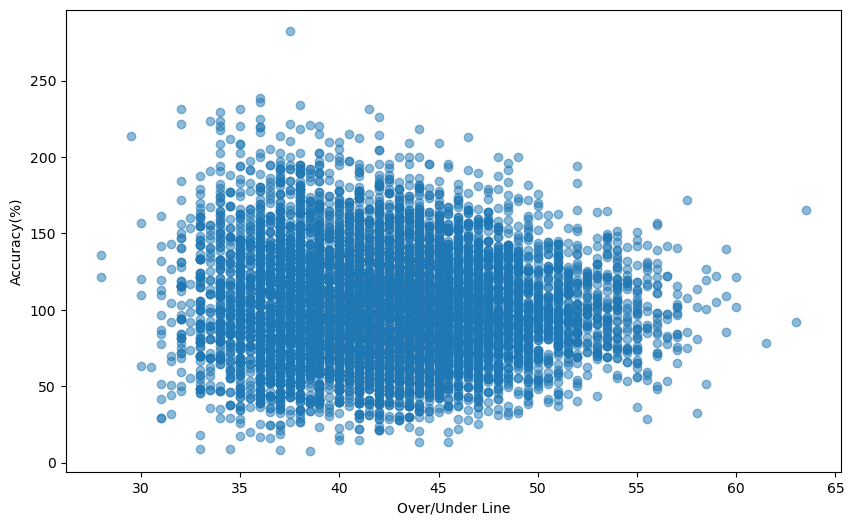

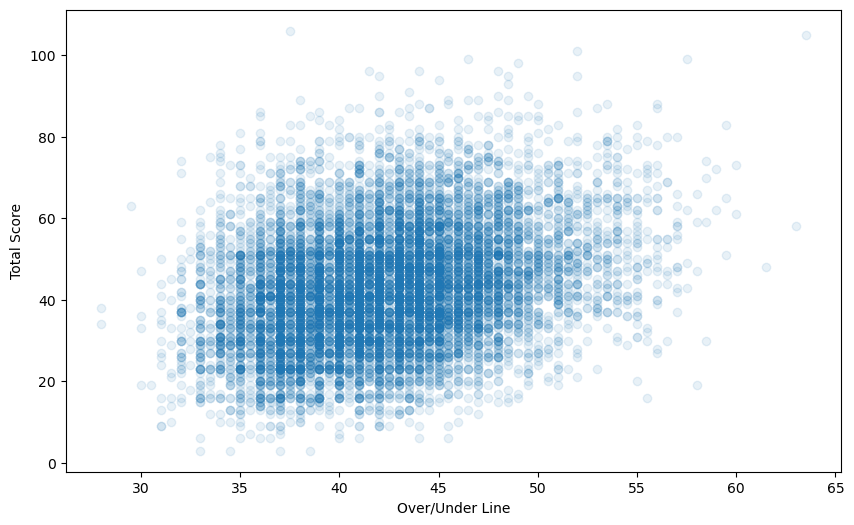

In [23]:
# Plot the data comparing the over_under_line to the total_score
x_values = filtered_scores_data['over_under_line']
y_values = filtered_scores_data['total_score']
plt.figure(figsize=(10,6))
plt.scatter(x_values, y_values, alpha=0.1)
plt.xlabel('Over/Under Line')
plt.ylabel('Total Score')
plt.show()